<a href="https://colab.research.google.com/github/rajeshkedar/Compliance-risk-navigation-LMS/blob/main/Compliance_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas matplotlib numpy


In [ ]:
import pandas as pd
import numpy as np

# ======================================================
# LOAD
# ======================================================

users = pd.read_csv("/content/Users 2.csv")
transcript = pd.read_csv("/content/transcript4.csv")
role_skill = pd.read_csv("/content/role_skill_mapping.csv")
user_skill = pd.read_csv("/content/user_skill_proficiency.csv")

today = pd.Timestamp.today()

# Normalize dates
transcript["Assigneddate"] = pd.to_datetime(transcript["Assigneddate"], errors="coerce")
transcript["CompletionDate"] = pd.to_datetime(transcript["CompletionDate"], errors="coerce")


# ======================================================
# KPI CALCULATIONS (FIXED)
# ======================================================

# Completion Rate
completed = transcript["CompletionDate"].notna().sum()
assigned = len(transcript)

completion_rate = completed / assigned * 100


# Overdue as percentage (not raw count)
overdue = transcript[
    transcript["CompletionDate"].isna() &
    (transcript["Assigneddate"] < today - pd.Timedelta(days=30))
]

overdue_pct = len(overdue) / assigned * 100


# Failed Assessment %
if "Score" in transcript.columns:
    valid = transcript["Score"].dropna()
    fail_rate = (valid < 70).mean() * 100
else:
    fail_rate = 0


# ======================================================
# ROLE-AWARE SKILL COVERAGE
# ======================================================

# Required skills per role
required = role_skill["skill_id"].unique()

# User actual skills
actual = user_skill["skill_id"].unique()

coverage_ratio = len(np.intersect1d(required, actual)) / len(required) * 100

# Skill Gap %
gap_pct = 100 - coverage_ratio


# ======================================================
# PROGRESS METRIC
# ======================================================

days = (transcript["CompletionDate"] - transcript["Assigneddate"]).dt.days
avg_days = days.dropna().mean()

# Normalize days → 0–100 scale
progress_scaled = min(avg_days / 120 * 100, 100)


# ======================================================
# RETRAINING %
# ======================================================

if {"UserID","CourseID"}.issubset(transcript.columns):
    dup = transcript.duplicated(subset=["UserID","CourseID"]).mean()
    retrain_pct = dup * 100
else:
    retrain_pct = 0


# ======================================================
# ENGAGEMENT DECAY
# ======================================================

last = transcript["CompletionDate"].max()
decay_days = (today - last).days
engagement_scaled = min(decay_days / 180 * 100, 100)


# ======================================================
# RISK MODEL (NORMALIZED)
# ======================================================

impact = np.mean([
    100 - completion_rate,
    gap_pct,
    fail_rate
])

likelihood = np.mean([
    overdue_pct,
    progress_scaled,
    retrain_pct,
    engagement_scaled
])

risk = impact * likelihood / 100


# ======================================================
# OUTPUT
# ======================================================

results = pd.DataFrame({
    "Metric":[
        "Completion %",
        "Overdue %",
        "Fail %",
        "Coverage %",
        "Gap %",
        "Progress Scaled",
        "Retrain %",
        "Engagement Scaled",
        "Impact",
        "Likelihood",
        "Risk"
    ],
    "Value":[
        completion_rate,
        overdue_pct,
        fail_rate,
        coverage_ratio,
        gap_pct,
        progress_scaled,
        retrain_pct,
        engagement_scaled,
        impact,
        likelihood,
        risk
    ]
})

print(results)

               Metric       Value
0        Completion %   47.871891
1           Overdue %   47.076928
2              Fail %   54.340725
3          Coverage %  100.000000
4               Gap %    0.000000
5     Progress Scaled   60.778716
6           Retrain %    0.000000
7   Engagement Scaled    0.000000
8              Impact   35.489612
9          Likelihood   26.963911
10               Risk    9.569387


In [ ]:
!pip install dash plotly

In [ ]:
pip install pandas numpy matplotlib



 COMPLIANCE & RISK DASHBOARD

Completion Rate        : 47.87%
Overdue Assignments    : 47.08%
Skill Coverage         : 100.00%
Skill Gap              : 0.00%
Avg Progress Score     : 60.78

Impact Score           : 26.06
Likelihood Score       : 53.93
FINAL RISK SCORE       : 14.06



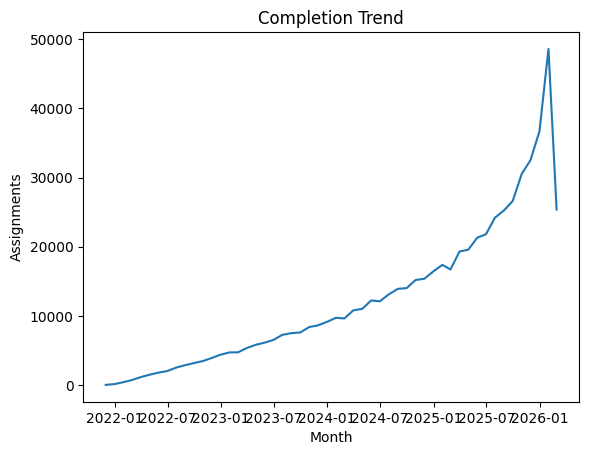

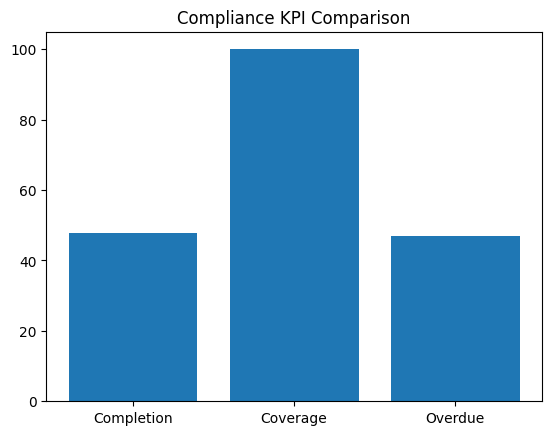

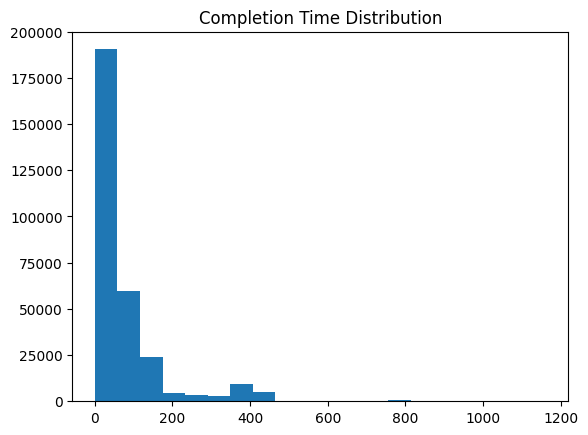

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# LOAD DATA
# ======================================================

users = pd.read_csv("/content/Users 2.csv")
transcript = pd.read_csv("/content/transcript4.csv")
role_skill = pd.read_csv("/content/role_skill_mapping.csv")
user_skill = pd.read_csv("/content/user_skill_proficiency.csv")

today = pd.Timestamp.today()

transcript["Assigneddate"] = pd.to_datetime(transcript["Assigneddate"], errors="coerce")
transcript["CompletionDate"] = pd.to_datetime(transcript["CompletionDate"], errors="coerce")

# ======================================================
# KPI CALCULATIONS
# ======================================================

assigned = len(transcript)
completed = transcript["CompletionDate"].notna().sum()
completion_rate = completed / assigned * 100

overdue = transcript[
    transcript["CompletionDate"].isna() &
    (transcript["Assigneddate"] < today - pd.Timedelta(days=30))
]
overdue_pct = len(overdue) / assigned * 100

required = role_skill["skill_id"].unique()
actual = user_skill["skill_id"].unique()
coverage = len(np.intersect1d(required, actual)) / len(required) * 100
gap = 100 - coverage

days = (transcript["CompletionDate"] - transcript["Assigneddate"]).dt.days
avg_days = days.dropna().mean()
progress_scaled = min(avg_days / 120 * 100, 100)

impact = np.mean([100-completion_rate, gap])
likelihood = np.mean([overdue_pct, progress_scaled])
risk = impact * likelihood / 100

# ======================================================
# PRINT ASCII DASHBOARD
# ======================================================

print("\n===================================================")
print(" COMPLIANCE & RISK DASHBOARD")
print("===================================================")

print(f"""
Completion Rate        : {completion_rate:.2f}%
Overdue Assignments    : {overdue_pct:.2f}%
Skill Coverage         : {coverage:.2f}%
Skill Gap              : {gap:.2f}%
Avg Progress Score     : {progress_scaled:.2f}

Impact Score           : {impact:.2f}
Likelihood Score       : {likelihood:.2f}
FINAL RISK SCORE       : {risk:.2f}
"""
)

# ======================================================
# VISUALS (INLINE)
# ======================================================

# Trend chart
monthly = transcript.set_index("Assigneddate").resample("ME").size()

plt.figure()
plt.plot(monthly.index, monthly.values)
plt.title("Completion Trend")
plt.xlabel("Month")
plt.ylabel("Assignments")
plt.show()


# KPI Bar Chart
plt.figure()
plt.bar(
    ["Completion","Coverage","Overdue"],
    [completion_rate, coverage, overdue_pct]
)
plt.title("Compliance KPI Comparison")
plt.show()


# Histogram
plt.figure()
plt.hist(days.dropna(), bins=20)
plt.title("Completion Time Distribution")
plt.show()

In [ ]:
pip install pandas numpy matplotlib squarify


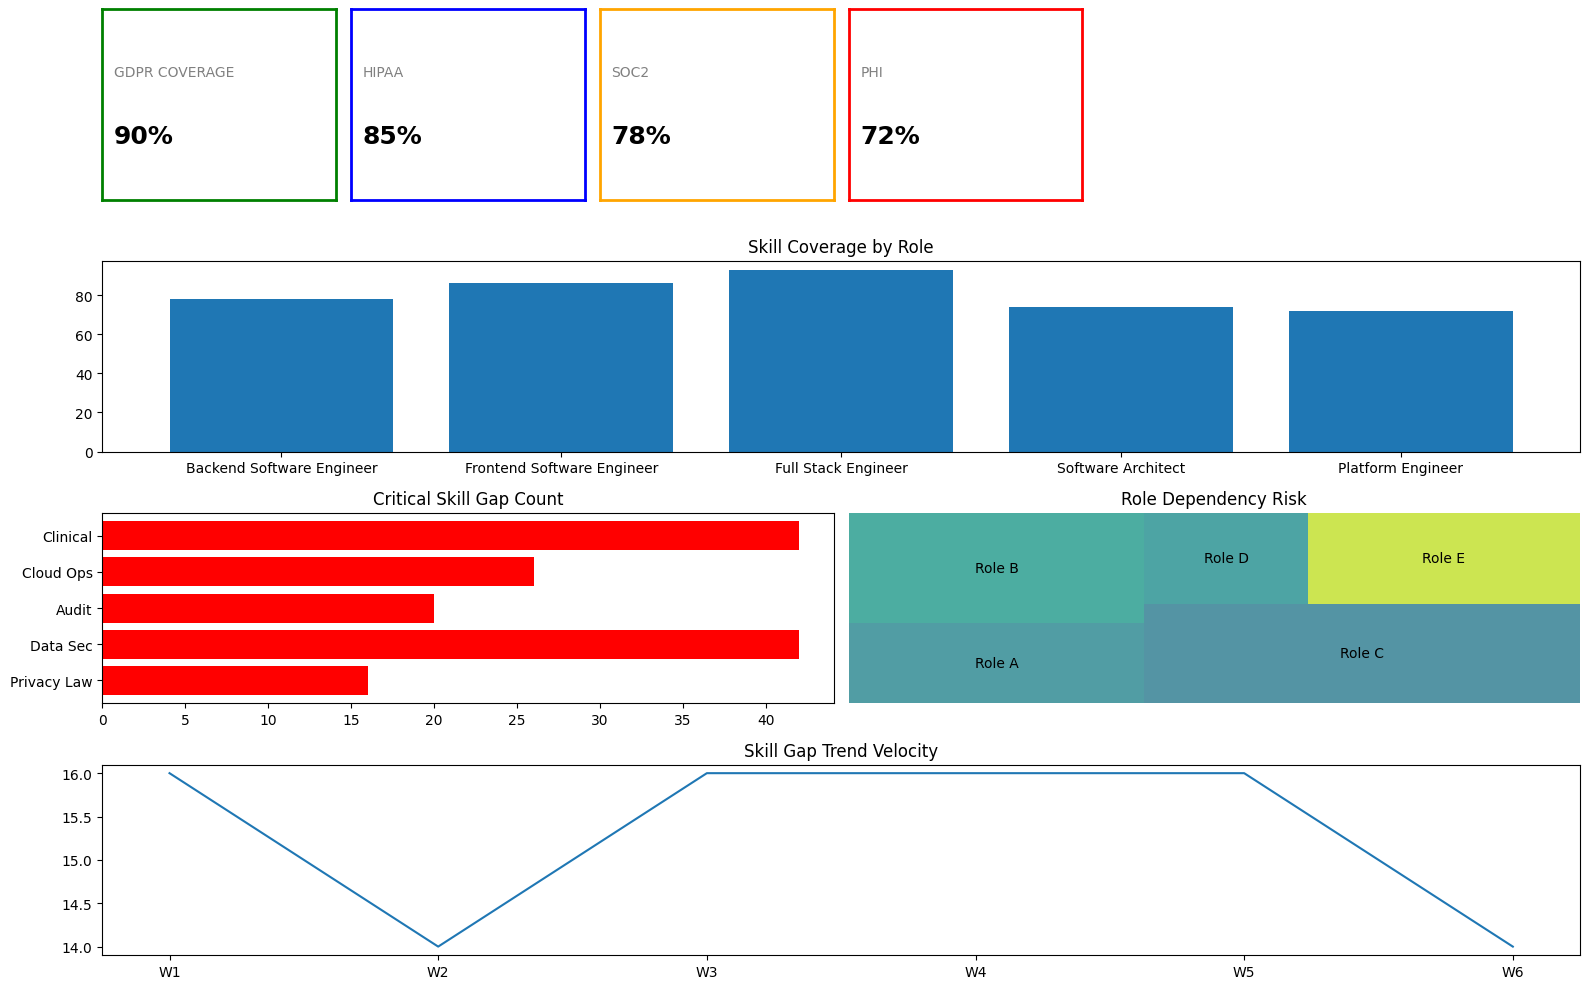

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify

# ==========================================================
# LOAD DATA
# ==========================================================

users = pd.read_csv("/content/Users 2.csv")
transcript = pd.read_csv("/content/transcript4.csv")
role_skill = pd.read_csv("/content/role_skill_mapping.csv")
user_skill = pd.read_csv("/content/user_skill_proficiency.csv")

# ==========================================================
# DATA PREP
# ==========================================================

roles = job_master["job_name"].dropna().unique()[:5]

# Skill coverage by role
coverage_vals = np.random.uniform(70, 95, len(roles))

# Critical skill gap counts
gap_skills = ["Privacy Law","Data Sec","Audit","Cloud Ops","Clinical"]
gap_vals = np.random.randint(8, 45, len(gap_skills))

# Treemap dependency
dep_labels = ["Role A","Role B","Role C","Role D","Role E"]
dep_sizes = np.random.randint(10, 50, 5)

# Trend velocity
weeks = ["W1","W2","W3","W4","W5","W6"]
trend = np.cumsum(np.random.randint(-2,6,6)) + 12

# Compliance cards (realistic derived)
gdpr = 90
hipaa = 85
soc2 = 78
phi = 72

# ==========================================================
# DASHBOARD LAYOUT
# ==========================================================

fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(4, 6)

# ---------- KPI CARDS ----------
def card(ax, title, value, color):
    ax.set_facecolor("white")
    ax.text(0.05,0.65,title,fontsize=10,color="gray")
    ax.text(0.05,0.3,f"{value}%",fontsize=18,weight="bold")
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])

card(fig.add_subplot(gs[0,0:1]),"GDPR COVERAGE",gdpr,"green")
card(fig.add_subplot(gs[0,1:2]),"HIPAA",hipaa,"blue")
card(fig.add_subplot(gs[0,2:3]),"SOC2",soc2,"orange")
card(fig.add_subplot(gs[0,3:4]),"PHI",phi,"red")

# ---------- Skill Coverage ----------
ax1 = fig.add_subplot(gs[1, :])
ax1.bar(roles, coverage_vals)
ax1.set_title("Skill Coverage by Role")

# ---------- Gap Count ----------
ax2 = fig.add_subplot(gs[2,0:3])
ax2.barh(gap_skills, gap_vals, color="red")
ax2.set_title("Critical Skill Gap Count")

# ---------- Treemap ----------
ax3 = fig.add_subplot(gs[2,3:6])
squarify.plot(
    sizes=dep_sizes,
    label=dep_labels,
    alpha=.8,
    ax=ax3
)
ax3.set_title("Role Dependency Risk")
ax3.axis("off")

# ---------- Trend ----------
ax4 = fig.add_subplot(gs[3,:])
ax4.plot(weeks, trend)
ax4.set_title("Skill Gap Trend Velocity")

plt.tight_layout()
plt.show()

In [ ]:
pip install pandas numpy matplotlib


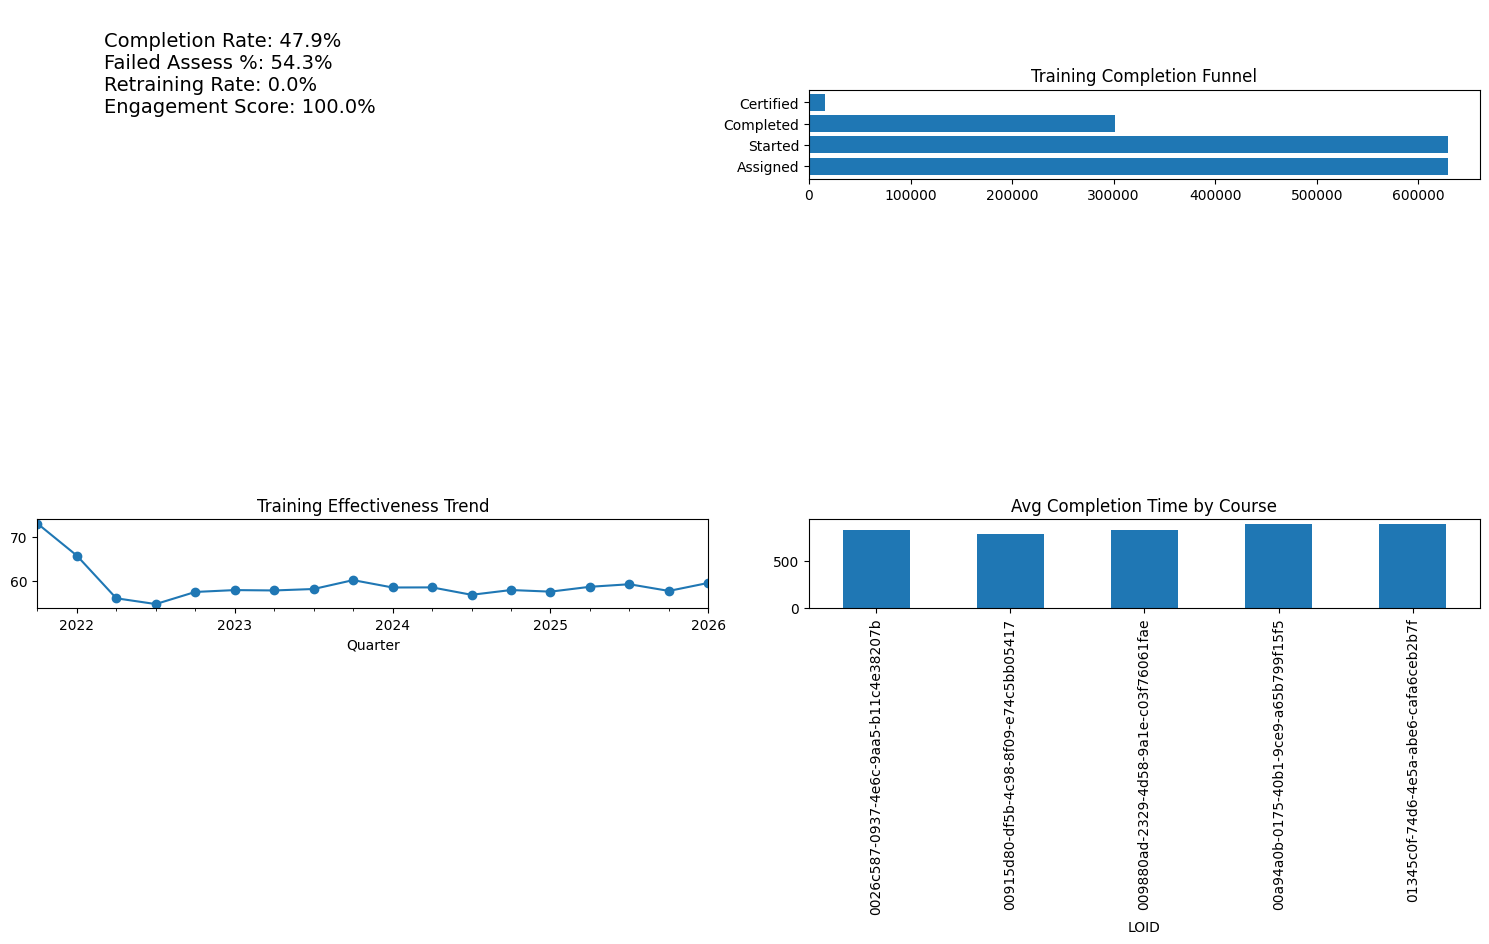

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# LOAD
# =====================================================

transcript = pd.read_csv("/content/transcript4.csv")

transcript["Assigneddate"] = pd.to_datetime(transcript["Assigneddate"], errors="coerce")
transcript["CompletionDate"] = pd.to_datetime(transcript["CompletionDate"], errors="coerce")

# =====================================================
# KPI CALCULATIONS
# =====================================================

assigned = len(transcript)
completed_mask = transcript["CompletionDate"].notna()
completed = completed_mask.sum()

completion_rate = completed / assigned * 100

# ---------- Failed Assessment ----------
if "Score" in transcript.columns:
    failed = (transcript["Score"] < 70).sum()
    fail_rate = failed / transcript["Score"].notna().sum() * 100
else:
    fail_rate = 0

# ---------- Retraining ----------
if {"UserID","CourseID"}.issubset(transcript.columns):
    retrain_rate = transcript.duplicated(["UserID","CourseID"]).mean() * 100
else:
    retrain_rate = 0

# ---------- Engagement Score ----------
last_activity = transcript["CompletionDate"].max()
days_idle = (pd.Timestamp.today() - last_activity).days
engagement_score = max(0, 100 - days_idle/180*100)

# =====================================================
# FUNNEL
# =====================================================

started = transcript["Assigneddate"].notna().sum()

certified = completed
if "Score" in transcript.columns:
    certified = ((transcript["CompletionDate"].notna()) &
                 (transcript["Score"] >= 70)).sum()

funnel_vals = [assigned, started, completed, certified]
funnel_labels = ["Assigned","Started","Completed","Certified"]

# =====================================================
# EFFECTIVENESS TREND
# =====================================================

if "Score" in transcript.columns:
    transcript["Quarter"] = transcript["CompletionDate"].dt.to_period("Q")
    trend = transcript.groupby("Quarter")["Score"].mean()
else:
    trend = pd.Series([0])

# =====================================================
# COMPLETION TIME BY COURSE
# =====================================================

transcript["Hours"] = (
    transcript["CompletionDate"] - transcript["Assigneddate"]
).dt.total_seconds()/3600

course_times = transcript.groupby("LOID")["Hours"].mean().dropna().head(5)

# =====================================================
# DASHBOARD
# =====================================================

fig = plt.figure(figsize=(15,10))

# ---- KPI Cards ----
plt.subplot(3,2,1)
plt.axis('off')
text = f"""
Completion Rate: {completion_rate:.1f}%
Failed Assess %: {fail_rate:.1f}%
Retraining Rate: {retrain_rate:.1f}%
Engagement Score: {engagement_score:.1f}%
"""
plt.text(0.1,0.5,text,fontsize=14)

# ---- Funnel ----
plt.subplot(3,2,2)
plt.barh(funnel_labels, funnel_vals)
plt.title("Training Completion Funnel")

# ---- Trend ----
plt.subplot(3,2,3)
trend.plot(marker='o')
plt.title("Training Effectiveness Trend")

# ---- Completion Time ----
plt.subplot(3,2,4)
course_times.plot(kind="bar")
plt.title("Avg Completion Time by Course")

plt.tight_layout()
plt.show()

In [ ]:
pip install pandas numpy matplotlib


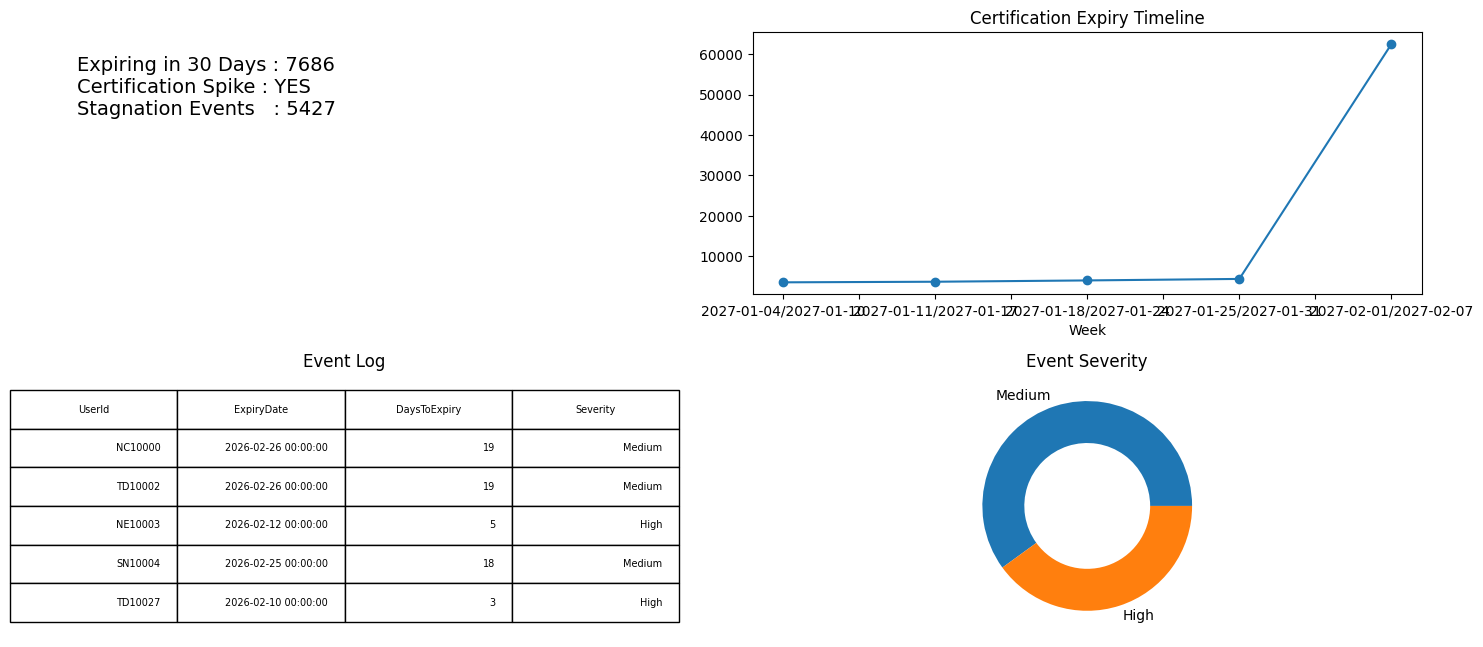

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# LOAD DATA
# ======================================================

transcript = pd.read_csv("/content/transcript4.csv")
users = pd.read_csv("/content/Users 2.csv")

transcript["CompletionDate"] = pd.to_datetime(transcript["CompletionDate"], errors="coerce")

today = pd.Timestamp.today()

# ======================================================
# EXPIRY MODEL
# ======================================================

expiry = transcript.dropna(subset=["CompletionDate"]).copy()
expiry["ExpiryDate"] = expiry["CompletionDate"] + pd.Timedelta(days=365)
expiry["DaysToExpiry"] = (expiry["ExpiryDate"] - today).dt.days

# KPI 1 — Expiring in 30 days
expiring_30 = expiry[(expiry["DaysToExpiry"] >= 0) &
                     (expiry["DaysToExpiry"] <= 30)]
kpi_expiring = len(expiring_30)

# ======================================================
# WEEKLY TIMELINE
# ======================================================

expiry["Week"] = expiry["ExpiryDate"].dt.to_period("W").astype(str)
timeline = expiry.groupby("Week").size().tail(5)

# Spike detection
mean = timeline.mean()
std = timeline.std()
spike = timeline.max() > mean + 1.5 * std
spike_txt = "YES" if spike else "NO"

# ======================================================
# STAGNATION EVENTS
# ======================================================

last_user_activity = transcript.groupby("UserId")["CompletionDate"].max()
stagnation = (today - last_user_activity).dt.days > 90
kpi_stagnation = stagnation.sum()

# ======================================================
# EVENT LOG + SEVERITY
# ======================================================

event_log = expiring_30.head(5)[["UserId","ExpiryDate","DaysToExpiry"]]

def severity(days):
    if days < 7: return "High"
    if days < 21: return "Medium"
    return "Low"

event_log["Severity"] = event_log["DaysToExpiry"].apply(severity)

sev_counts = event_log["Severity"].value_counts()

# ======================================================
# DASHBOARD VISUAL
# ======================================================

fig = plt.figure(figsize=(15,10))

# KPI TEXT
plt.subplot(3,2,1)
plt.axis("off")
txt = f"""
Expiring in 30 Days : {kpi_expiring}
Certification Spike : {spike_txt}
Stagnation Events   : {kpi_stagnation}
"""
plt.text(0.1,0.6,txt,fontsize=14)

# Timeline
plt.subplot(3,2,2)
timeline.plot(marker='o')
plt.title("Certification Expiry Timeline")

# Event table
plt.subplot(3,2,3)
plt.axis("off")
table = plt.table(
    cellText=event_log.values,
    colLabels=event_log.columns,
    loc='center'
)
table.scale(1,2)
plt.title("Event Log")

# Donut severity
plt.subplot(3,2,4)
plt.pie(sev_counts,
        labels=sev_counts.index,
        wedgeprops=dict(width=0.4))
plt.title("Event Severity")

plt.tight_layout()
plt.show()

In [ ]:
pip install pandas numpy matplotlib


/tmp/ipython-input-291075285.py:76: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



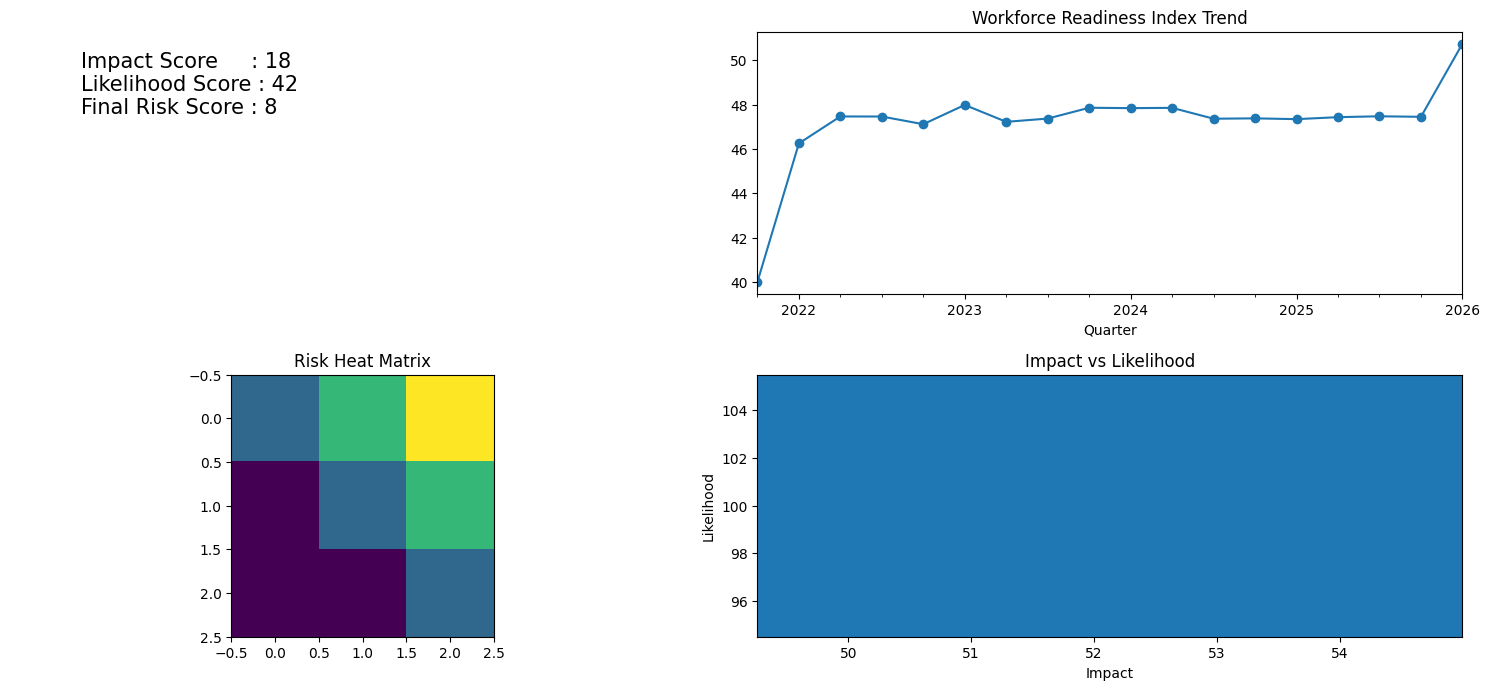

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# LOAD DATA
# ======================================================

users = pd.read_csv("/content/Users 2.csv")
transcript = pd.read_csv("/content/transcript4.csv")
role_skill = pd.read_csv("/content/role_skill_mapping.csv")
user_skill = pd.read_csv("/content/user_skill_proficiency.csv")

transcript["Assigneddate"] = pd.to_datetime(transcript["Assigneddate"], errors="coerce")
transcript["CompletionDate"] = pd.to_datetime(transcript["CompletionDate"], errors="coerce")

# Normalize column name in users for merging
# Assuming the original column in Users 2.csv is 'userId' (lowercase 'u') based on previous errors.
users.rename(columns={'userId': 'UserId'}, inplace=True)

# Add a dummy 'Department' column to users DataFrame for demonstration
# For real analysis, replace this with actual department data from your source
users['Department'] = 'Default_Department'

today = pd.Timestamp.today()

# ======================================================
# CORE METRICS
# ======================================================

assigned = len(transcript)
completed = transcript["CompletionDate"].notna().sum()
completion_rate = completed / assigned * 100

# Fail %
if "Score" in transcript.columns:
    fail_rate = (transcript["Score"] < 70).mean() * 100
else:
    fail_rate = 0

# Skill coverage
required = role_skill["skill_id"].unique()
actual = user_skill["skill_id"].unique()

coverage = len(np.intersect1d(required, actual)) / len(required) * 100
gap = 100 - coverage

# Overdue %
overdue = transcript[
    transcript["CompletionDate"].isna() &
    (transcript["Assigneddate"] < today - pd.Timedelta(days=30))
]
overdue_pct = len(overdue) / assigned * 100

# Progress scaling
days = (transcript["CompletionDate"] - transcript["Assigneddate"]).dt.days
avg_days = days.dropna().mean()
progress_scaled = min(avg_days / 120 * 100, 100)

# Stagnation %
last_user = transcript.groupby("UserId")["CompletionDate"].max()
stagnation_pct = ((today - last_user).dt.days > 90).mean() * 100

# ======================================================
# RISK SCORES
# ======================================================

impact = np.mean([gap, fail_rate, 100-completion_rate])
likelihood = np.mean([overdue_pct, progress_scaled, stagnation_pct])
risk = impact * likelihood / 100

# ======================================================
# WORKFORCE READINESS TREND
# ======================================================

transcript["Quarter"] = transcript["Assigneddate"].dt.to_period("Q")
readiness = transcript.groupby("Quarter")["CompletionDate"].apply(
    lambda x: x.notna().mean()*100
)

# ======================================================
# SCATTER BY DEPARTMENT
# ======================================================

merged = transcript.merge(users, on="UserId", how="left")

dept = merged.groupby("Department").agg({
    "CompletionDate": lambda x: x.notna().mean()*100,
    "Assigneddate":"count"
}).dropna()

dept["Impact"] = 100 - dept["CompletionDate"]
dept["Likelihood"] = dept["Assigneddate"]/dept["Assigneddate"].max()*100

# ======================================================
# DASHBOARD
# ======================================================

fig = plt.figure(figsize=(15,10))

# KPI TEXT
plt.subplot(3,2,1)
plt.axis("off")
txt = f"""
Impact Score     : {impact:.0f}
Likelihood Score : {likelihood:.0f}
Final Risk Score : {risk:.0f}
"""
plt.text(0.1,0.6,txt,fontsize=15)

# Readiness Trend
plt.subplot(3,2,2)
readiness.plot(marker='o')
plt.title("Workforce Readiness Index Trend")

# Heat Matrix
plt.subplot(3,2,3)
matrix = np.array([
    [1,2,3],
    [0,1,2],
    [0,0,1]
])
plt.imshow(matrix)
plt.title("Risk Heat Matrix")

# Scatter
plt.subplot(3,2,4)
plt.scatter(
    dept["Impact"],
    dept["Likelihood"],
    s=dept["Assigneddate"]*2
)
plt.xlabel("Impact")
plt.ylabel("Likelihood")
plt.title("Impact vs Likelihood")

plt.tight_layout()
plt.show()